- Please run `drug_target_prediction/run_training.sh`.
- The results of the consensus target predictions are provided in `drug_target_prediction/results`, so it is possible to reproduce this notebook.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 16

In [2]:
#####################
# Load Target Genes
#####################
target_file = "drug_target_prediction/results/cpd_gene_pairs.csv"
t_target=pd.read_csv(target_file)

cpd2target={}
target_gene_id = t_target.Broad_target_gene_id.tolist()

for k,v in zip(t_target.term_name.tolist(), target_gene_id):
    if str(v) == 'nan':
        continue
    ck = k.split('Cpd:')[1].split(':')[0] + '@'
    for t in v.split(':'):
        t = t+'@'
        if ck not in cpd2target:
            cpd2target[ck] = [t]
        else:
            if t not in cpd2target[ck]:
                cpd2target[ck].append(t)
    cpd2target[ck] = list(set(cpd2target[ck]))

delk = []
for k in cpd2target:
    if len(cpd2target[k]) > 5:
        delk.append(k)
for k in delk:
    del cpd2target[k]

target_num = []
for c in cpd2target:
    target_num.append(len(cpd2target[c]))
print('Average tragets per compound:', np.mean(target_num))

all_target_genes = set()
t_target["Broad_target_gene_id"] = t_target["Broad_target_gene_id"].fillna("")
for gids in t_target["Broad_target_gene_id"]:
    if gids != "":
        all_target_genes.update(gids.split(":"))

#####################
# Load Signatures
#####################
t_sigs = pd.read_csv("drug_target_prediction/results/L1000_PhaseI_and_II.csv")
all_sigs_genes = set()
for gids in t_sigs["gids"]:
    all_sigs_genes.update(gids.split(","))

all_genes = sorted(list(all_target_genes | all_sigs_genes))
all_genes = np.array(all_genes).astype(int)
print("Number of all genes:", len(all_genes))
cutoff = 0.05
topk_cutoff = int(len(all_genes) * cutoff)

Average tragets per compound: 2.164450354609929
Number of all genes: 10615


In [3]:
#####################
# Load Results
#####################
bases = ["drug_target_prediction/results/FRoGS_original-consensus_gene_rank",
         "drug_target_prediction/results/context_independent_GRN-consensus_gene_rank",
         "drug_target_prediction/results/context_dependent_GRN-consensus_gene_rank",
         "drug_target_prediction/results/omnipath-consensus_gene_rank",
         "drug_target_prediction/results/STRING-consensus_gene_rank"]
names = ["FRoGS", "Context-independent GRNs", "Context-dependent GRNs", "OmniPath", "STRING"]

results_recall= {}
random_recalls = []
for base, name in zip(bases, names):
    files = os.listdir(base)

    recalls = []
    random_recalls_iter = []
    for f in files:
        rank_df = pd.read_table(os.path.join(base, f))
        sorted_labels = rank_df["label"].values

        # add genes that are in all_genes but not in rank_df["gene"]
        add_genes = np.setdiff1d(all_genes, rank_df["gene"].values)
        add_genes = pd.DataFrame({"gene": add_genes})
        # find target genes in add_genes
        cpd = f.replace(".tsv", "")
        targets = cpd2target.get(cpd+"@", [])
        if len(targets) > 0:
            targets = [int(t.replace("@", "")) for t in targets]
            add_genes["label"] = add_genes["gene"].isin(targets).astype(int)
        else:
            add_genes["label"] = 0
        
        sorted_labels = np.concatenate([sorted_labels, add_genes["label"].values])

        # calculate recall (whether at least one positive label exists in top i%)) which the original paper calls "recall"
        total_positives = np.sum(sorted_labels)
        if total_positives > 0:
            # For each position i, check if there's at least one positive in top i positions
            hit_rate = np.zeros(topk_cutoff)
            for i in range(topk_cutoff):
                hit_rate[i] = 1 if np.sum(sorted_labels[:i+1]) > 0 else 0
              
            hit_rate[len(rank_df):] = 0 # to be fair, we only consider the top k candidates that are actually in the rank_df
        else:
            hit_rate = np.zeros(topk_cutoff)
        
        recalls.append(hit_rate)

        # random recall
        random_labels = np.random.permutation(sorted_labels)
        total_positives = np.sum(random_labels)
        if total_positives > 0:
            random_hit_rate = np.zeros(topk_cutoff)
            for i in range(topk_cutoff):
                random_hit_rate[i] = 1 if np.sum(random_labels[:i+1]) > 0 else 0
        else:
            random_hit_rate = np.zeros(topk_cutoff)
        random_recalls_iter.append(random_hit_rate)

    recalls = np.stack(recalls, axis=0).mean(axis=0)
    results_recall[name] = recalls
    random_recalls.append(np.stack(random_recalls_iter, axis=0).mean(axis=0))

results_recall["Percentage of top candidates"] = np.arange(1, topk_cutoff+1) / len(all_genes)

random_recalls = np.stack(random_recalls, axis=0).mean(axis=0)
results_recall["Random"] = random_recalls
results_recall = pd.DataFrame(results_recall)
# results_recall.to_csv("../data/fig5/20250120_mean_hit/mean_recall.csv", index=False)

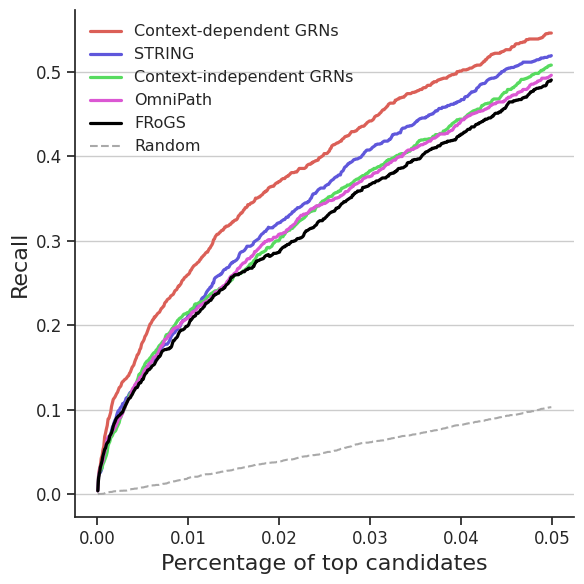

In [4]:
# Plot
palette = sns.color_palette("hls")
c_original = "black"
c_relnet2vec = palette[2] # green
c_c_relnet2vec = palette[0] # red
c_omnipath = palette[-1] # purple
c_string = palette[-2] # blue
fig, ax = plt.subplots(figsize=(6,6))
sns.lineplot(x="Percentage of top candidates", y=names[2], data=results_recall, ax=ax, color=c_c_relnet2vec, label=names[2], lw=2.3)
sns.lineplot(x="Percentage of top candidates", y=names[4], data=results_recall, ax=ax, color=c_string, label=names[4], lw=2.3)
sns.lineplot(x="Percentage of top candidates", y=names[1], data=results_recall, ax=ax, color=c_relnet2vec, label=names[1], lw=2.3)
sns.lineplot(x="Percentage of top candidates", y=names[3], data=results_recall, ax=ax, color=c_omnipath, label=names[3], lw=2.3)
sns.lineplot(x="Percentage of top candidates", y=names[0], data=results_recall, ax=ax, color=c_original, label=names[0], lw=2.3)
sns.lineplot(x="Percentage of top candidates", y="Random", data=results_recall, linestyle="--", ax=ax, color="darkgray", label="Random", lw=1.5)
ax.set_ylabel("Recall")
ax.set_xlabel("Percentage of top candidates")
ax.grid(True, axis="y")
plt.legend(fontsize=11.5, frameon=False)
plt.tight_layout()
fig.savefig("../data/fig5/fig5.drug_target_prediction_recall.png")

plt.show()